# Экспериментальная оптимизация маркетплейса онлайн-курсов

**Описание проекта:**
1. В проекте исследуется влияние цены и рейтинга курса на вовлечённость студентов и выручку образовательной платформы.
2. На основе данных двух платформ смоделированы продуктовые A/B-эксперименты и проверены гипотезы с использованием статистических тестов.

**Цель исследования:**
1. Оценить влияние факторов продукта (цены и рейтинга курса) на вовлечённость пользователей и выручку платформы с использованием экспериментального подхода.

**Общий вывод:**
1. Udemy демонстрирует более масштабный рынок и сильный эффект «массовости».
2. Stepik — более компактная платформа с умеренной концентрацией студентов.
3. Популярность курса определяется не только рейтингом, но и масштабом платформы, маркетингом и охватом аудитории.
4. A/B-тест 1 показал p-value < 0.05, что свидетельствует о статистически значимом эффекте. Нулевая гипотеза отвергается: добавление курсов с рейтингом ≥ 4.5 приводит к росту вовлечённости.
5. A/B-тест 2 также показал статистическую значимость (p-value < 0.05), однако практический эффект отрицательный — показатели снизились на 65%. Несмотря на значимость, внедрение данного изменения не рекомендуется.

**Дизайн эксперимента и анализ данных:**
1. Анализ данных
2. Формулировка продуктовых гипотез
3. Определение primary и guardrail-метрик
4. Квази-A/B сегментация
5. Проверка статистической значимости (Mann–Whitney U))
6. Расчёт uplift (прироста)
7. Общий вывод
   



## Анализ Данных

In [68]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [69]:
# Открытие данных
stepik = pd.read_csv(r"C:\Users\Денис\Desktop\Udemy and Stepik Programming Courses\stepik_courses_data.csv")
udemy = pd.read_csv(r"C:\Users\Денис\Desktop\Udemy and Stepik Programming Courses\udemy_courses_data.csv")

In [70]:
#Обзор таблицы 
stepik

,index,title,description,difficulty,certificate_available,students_count,price,rating,reviews_count,source,course
0,82541,"""Поколение Python"": курс для профессионалов","Курс продолжает серию ""Поколение Python"" и рас...",Продвинутый уровень,True,15164,7900,5.0,1647,stepik,Python
1,189436,Асинхронность в Python: от новичка до эксперта,"Курс для тех, кто хочет не просто «пользоватьс...",Средний уровень,True,607,3700,5.0,16,stepik,Python
2,52054,Полный курс Python для начинающих + ООП,Полный курс Python для начинающих с задачами. ...,Начальный уровень,True,944,4790,4.6,36,stepik,Python
3,234245,Лучший по Python,"Самый интересный курс для тех, кто хочет начат...",Начальный уровень,False,191,4300,5.0,5,stepik,Python
4,190099,Многопроцессорный Python,Курс проведёт вас от основ до эксперта в много...,Начальный уровень,True,800,2900,4.9,26,stepik,Python
...,...,...,...,...,...,...,...,...,...,...,...
2051,257685,Python: Data Harvesting & Cyber Defense — Stepik,Эта специализация объединяет две критически ва...,Начальный уровень,False,NaN,5950,NaN,NaN,stepik,Анализ данных
2052,259387,Бизнес аналитик в IT (практика с поддержкой ав...,Практический курс по бизнес-анализу в IT: ника...,Средний уровень,True,9,8415,5.0,1,stepik,Анализ данных
2053,259983,Python. Алгоритмы фильтрации,"Узнайте, как реализовать алгоритмы фильтрации ...",Начальный уровень,False,103,NaN,5.0,1,stepik,Анализ данных
2054,261052,Бизнес аналитик в IT (полный курс+практика с п...,Программа из двух курсов: полный курс по бизне...,Начальный уровень,False,8,9945,5.0,1,stepik,Анализ данных


In [71]:
# Приводим колонки к общему виду (у платформ разные названия полей)
stepik = stepik.rename(columns={
    "students_count": "students",
    "source": "platform"
})

In [72]:
# проверка на NAN таблицы stepik
print(stepik.isna().sum())

index                      0
title                      0
description               36
difficulty               397
certificate_available      0
students                  24
price                    702
rating                   494
reviews_count            495
platform                   1
course                     2
dtype: int64


Так как в данной таблице стлобцы имеют много строк со значением NAN. Было принято следующее решение:
1. В столбцах students и reviews_count строки со значением nan, заменить на 0.
2. В столбцах price и ratingt строки со значением nan, заменить на среднее значение. 

In [73]:
# для столбца students и reviews_count, nan заменяем на 0
stepik[['students','reviews_count']] = stepik[['students','reviews_count']].fillna(0)

In [74]:
# дял столбца rating берем среднее значение
stepik['rating'] = stepik['rating'].fillna(stepik['rating'].mean()).astype(float)

In [75]:
# дял столбца price берем среднее значение преобразовав во float
stepik['price'] = stepik['price'].astype(str).str.replace(',', '.', regex=False)
stepik['price'] = pd.to_numeric(stepik['price'], errors='coerce')
stepik['price'] = stepik['price'].fillna(stepik['price'].mean()).astype(float)

In [76]:
stepik.head()

,index,title,description,difficulty,certificate_available,students,price,rating,reviews_count,platform,course
0,82541,"""Поколение Python"": курс для профессионалов","Курс продолжает серию ""Поколение Python"" и рас...",Продвинутый уровень,True,15164,7900.0,5.0,1647,stepik,Python
1,189436,Асинхронность в Python: от новичка до эксперта,"Курс для тех, кто хочет не просто «пользоватьс...",Средний уровень,True,607,3700.0,5.0,16,stepik,Python
2,52054,Полный курс Python для начинающих + ООП,Полный курс Python для начинающих с задачами. ...,Начальный уровень,True,944,4790.0,4.6,36,stepik,Python
3,234245,Лучший по Python,"Самый интересный курс для тех, кто хочет начат...",Начальный уровень,False,191,4300.0,5.0,5,stepik,Python
4,190099,Многопроцессорный Python,Курс проведёт вас от основ до эксперта в много...,Начальный уровень,True,800,2900.0,4.9,26,stepik,Python


In [77]:
# Обзор таблицы
udemy

,index,title,description,difficulty,certificate_available,students,price,rating,reviews_count,source,course
0,datascience/,Data Science A-Z: Hands-On Exercises & ChatGPT...,Learn Data Science step by step through real A...,Все уровни,True,223 757 студента,10890.0,"4,6",34751,udemy,Обработка и анализ данных
1,machine-learning-for-absolute-beginners-level-1/,Machine Learning for Absolute Beginners - Level 1,Learn the Fundamental Concepts of Artificial I...,Начальный,True,120 723 студента,6090.0,"4,5",31061,udemy,Обработка и анализ данных
2,sql-150-2025/,SQL 150 вопросов для уверенного собеседования ...,Мастер-класс – 150 вопросов для собеседования ...,Все уровни,False,6 студента,5390.0,"0,0",0,udemy,Обработка и анализ данных
3,ai-machinelearning-ru/,Искусственный интеллект и Машинное обучение + ...,"Научитесь понимать технологии ИИ, Машинное обу...",Все уровни,True,2 123 студента,6090.0,"4,5",481,udemy,Обработка и анализ данных
4,langchain/,LangChain- Develop AI Agents with LangChain & ...,Learn LangChain and LangGraph by building real...,Средний,True,141 782 студента,5390.0,"4,6",41585,udemy,Обработка и анализ данных
...,...,...,...,...,...,...,...,...,...,...,...
3438,200-statistics-and-probability-interview-quest...,300+ Statistics and Probability Interview Ques...,Master Probability & Statistics MCQs for Data ...,Все уровни,False,3 студента,5390.0,"0,0",0,udemy,Обработка и анализ данных
3439,learn-gecode-programming-from-scratch/,Introduction to Gecode Programming - Part 2,Master Constraint Programming with Gecode,Все уровни,True,162 студента,5390.0,"0,0",0,udemy,Обработка и анализ данных
3440,master-ai-agent-development-langchain-openai-o...,"Master AI Agent Development: LangChain, OpenAI...","Learn to build, deploy, and fine-tune intellig...",Средний,True,5 студента,5390.0,"0,0",0,udemy,Обработка и анализ данных
3441,python-machine-learning-data-science-russian/,Машинное обучение в Python: Machine Learning &...,"Изучите NumPy, Pandas, Matplotlib, Seaborn, Sc...",Все уровни,True,4 455 студента,5390.0,"4,7",800,udemy,Обработка и анализ данных


In [78]:
# проверка на NAN таблицы udemy
print(udemy.isna().sum())

index                    0
title                    0
description              1
difficulty               0
certificate_available    0
students                 0
price                    0
rating                   0
reviews_count            0
source                   0
course                   0
dtype: int64


In [79]:
# Столбец rating таблицы udemy заменяем запятую на точку и приводим к типу float 
udemy['rating'] = udemy['rating'].astype(str).str.replace(',', '.', regex=False).astype(float)

In [80]:
# Стольбец students оставляем только колличесто студентов и приводим к типу int
# Приводим всё к строкам
udemy['students'] = udemy['students'].astype(str)

# Извлекаем только числа
# Находим все цифры и объединяем в одно число
udemy['students'] = udemy['students'].str.findall(r'\d+').apply(lambda x: ''.join(x)).astype(int)

In [81]:
udemy.head()

,index,title,description,difficulty,certificate_available,students,price,rating,reviews_count,source,course
0,datascience/,Data Science A-Z: Hands-On Exercises & ChatGPT...,Learn Data Science step by step through real A...,Все уровни,True,223757,10890.0,4.6,34751,udemy,Обработка и анализ данных
1,machine-learning-for-absolute-beginners-level-1/,Machine Learning for Absolute Beginners - Level 1,Learn the Fundamental Concepts of Artificial I...,Начальный,True,120723,6090.0,4.5,31061,udemy,Обработка и анализ данных
2,sql-150-2025/,SQL 150 вопросов для уверенного собеседования ...,Мастер-класс – 150 вопросов для собеседования ...,Все уровни,False,6,5390.0,0.0,0,udemy,Обработка и анализ данных
3,ai-machinelearning-ru/,Искусственный интеллект и Машинное обучение + ...,"Научитесь понимать технологии ИИ, Машинное обу...",Все уровни,True,2123,6090.0,4.5,481,udemy,Обработка и анализ данных
4,langchain/,LangChain- Develop AI Agents with LangChain & ...,Learn LangChain and LangGraph by building real...,Средний,True,141782,5390.0,4.6,41585,udemy,Обработка и анализ данных


In [82]:
# Приводим колонки к общему виду (у платформ разные названия полей)
udemy = udemy.rename(columns={
    "source": "platform"
})

## Формулировка продуктовых гипотез
1. Увеличивает ли снижение цены количество записей на курс?
2. Стоит ли выделять курсы с самым высоким рейтингом в результатах поиска?


In [83]:
# Убираем шум и объединяем данные по требуемым колонкам.
cols = ["platform", "price", "students", "rating"]

all_courses = pd.concat(
    [udemy[cols], stepik[cols]],
    ignore_index=True
)

In [84]:
all_courses

,platform,price,students,rating
0,udemy,10890.000000,223757,4.600000
1,udemy,6090.000000,120723,4.500000
2,udemy,5390.000000,6,0.000000
3,udemy,6090.000000,2123,4.500000
4,udemy,5390.000000,141782,4.600000
...,...,...,...,...
5494,stepik,5950.000000,0,5.148656
5495,stepik,8415.000000,9,5.000000
5496,stepik,5191.310141,103,5.000000
5497,stepik,9945.000000,8,5.000000


In [85]:
all_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5499 entries, 0 to 5498
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   platform  5498 non-null   object 
 1   price     5499 non-null   float64
 2   students  5499 non-null   object 
 3   rating    5499 non-null   float64
dtypes: float64(2), object(2)
memory usage: 172.0+ KB


In [86]:
all_courses["students"] = pd.to_numeric(all_courses["students"], errors="coerce").fillna(0)

## Метрики:
1. Среднее количество студентов на курс (основная)
2. Показатель дохода (цена × количество студентов)
3. Средний uplift(прирост)
4. p-value

In [87]:
# Очистка данных 
all_courses = all_courses.dropna(subset=["students", "rating"])
all_courses = all_courses[all_courses["students"] > 0]

In [88]:
all_courses

,platform,price,students,rating
0,udemy,10890.000000,223757.0,4.600000
1,udemy,6090.000000,120723.0,4.500000
2,udemy,5390.000000,6.0,0.000000
3,udemy,6090.000000,2123.0,4.500000
4,udemy,5390.000000,141782.0,4.600000
...,...,...,...,...
5492,stepik,5191.310141,201.0,5.148656
5495,stepik,8415.000000,9.0,5.000000
5496,stepik,5191.310141,103.0,5.000000
5497,stepik,9945.000000,8.0,5.000000


In [89]:
all_courses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5439 entries, 0 to 5498
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   platform  5439 non-null   object 
 1   price     5439 non-null   float64
 2   students  5439 non-null   float64
 3   rating    5439 non-null   float64
dtypes: float64(3), object(1)
memory usage: 212.5+ KB


In [90]:
# Считаем базовые метрики по платформам (понять общее отличие стратегий)
summary = all_courses.groupby("platform").agg(
    avg_price=("price", "mean"),
    median_price=("price", "median"),
    avg_students=("students", "mean"),
    median_students=("students", "median"),
    avg_rating=("rating", "mean"),
    courses=("platform", "count")
).reset_index()

In [91]:
# Обзор метрик
summary

,platform,avg_price,median_price,avg_students,median_students,avg_rating,courses
0,stepik,5177.380634,4900.0,3051.183744,180.0,4.812664,2030
1,udemy,5528.574362,5390.0,8385.709006,1230.0,4.286154,3409


In [92]:
# Вводим value-метрики (Студенты на 1 доллар, оценить «отдачу» от цены)
all_courses["students_per_price"] = (all_courses["students"] / all_courses["price"].replace(0, 1))

In [93]:
all_courses

,platform,price,students,rating,students_per_price
0,udemy,10890.000000,223757.0,4.600000,20.547016
1,udemy,6090.000000,120723.0,4.500000,19.823153
2,udemy,5390.000000,6.0,0.000000,0.001113
3,udemy,6090.000000,2123.0,4.500000,0.348604
4,udemy,5390.000000,141782.0,4.600000,26.304638
...,...,...,...,...,...
5492,stepik,5191.310141,201.0,5.148656,0.038719
5495,stepik,8415.000000,9.0,5.000000,0.001070
5496,stepik,5191.310141,103.0,5.000000,0.019841
5497,stepik,9945.000000,8.0,5.000000,0.000804


In [94]:
# совместить масштаб и качество
all_courses["value_score"] = (
   all_courses["rating"] * all_courses["students"] / all_courses["price"].replace(0, 1)
)

In [95]:
all_courses

,platform,price,students,rating,students_per_price,value_score
0,udemy,10890.000000,223757.0,4.600000,20.547016,94.516272
1,udemy,6090.000000,120723.0,4.500000,19.823153,89.204187
2,udemy,5390.000000,6.0,0.000000,0.001113,0.000000
3,udemy,6090.000000,2123.0,4.500000,0.348604,1.568719
4,udemy,5390.000000,141782.0,4.600000,26.304638,121.001336
...,...,...,...,...,...,...
5492,stepik,5191.310141,201.0,5.148656,0.038719,0.199348
5495,stepik,8415.000000,9.0,5.000000,0.001070,0.005348
5496,stepik,5191.310141,103.0,5.000000,0.019841,0.099204
5497,stepik,9945.000000,8.0,5.000000,0.000804,0.004022


## Квази-A/B сегментация

In [96]:
# сравниваем A и B на одном уровне
value_summary = all_courses.groupby("platform").agg(
    avg_students_per_price=("students_per_price", "mean"),
    median_students_per_price=("students_per_price", "median"),
    avg_value_score=("value_score", "mean")
).reset_index()

In [97]:
value_summary

,platform,avg_students_per_price,median_students_per_price,avg_value_score
0,stepik,0.787241,0.069027,3.723438
1,udemy,1.476917,0.227087,6.508930


In [98]:
# получаем одну таблицу для выводов
comparison = summary.merge(value_summary, on="platform")

In [99]:
comparison

,platform,avg_price,median_price,avg_students,median_students,avg_rating,courses,avg_students_per_price,median_students_per_price,avg_value_score
0,stepik,5177.380634,4900.0,3051.183744,180.0,4.812664,2030,0.787241,0.069027,3.723438
1,udemy,5528.574362,5390.0,8385.709006,1230.0,4.286154,3409,1.476917,0.227087,6.508930


In [100]:
# получаем колличество , средние и медианные значения по 2 платформам
paid = all_courses[all_courses["price"] > 0]

paid.groupby("platform")["price"].agg(
    count="count",
    median="median",
    mean="mean"
)

,count,median,mean
platform,,,
stepik,2030,4900.0,5177.380634
udemy,3409,5390.0,5528.574362


<Figure size 640x480 with 0 Axes>

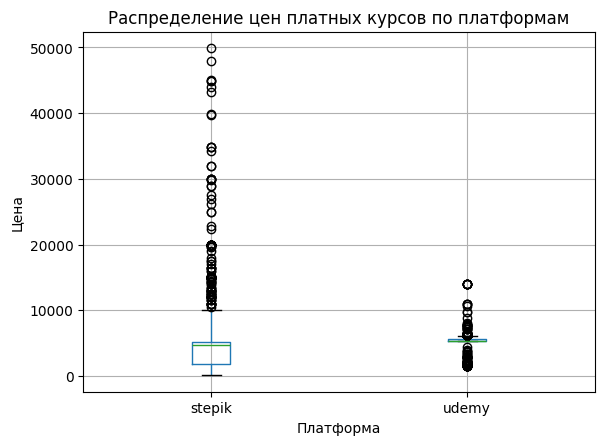

In [101]:
# Распределение цен по платформам (сравнить ценовые стратегии Udemy и Stepik.)
import matplotlib.pyplot as plt
filtered = all_courses[all_courses["price"] < 50000]
plt.figure()
filtered.boxplot(column="price", by="platform")
plt.title("Распределение цен платных курсов по платформам")
plt.suptitle("")
plt.xlabel("Платформа")
plt.ylabel("Цена")
plt.show()


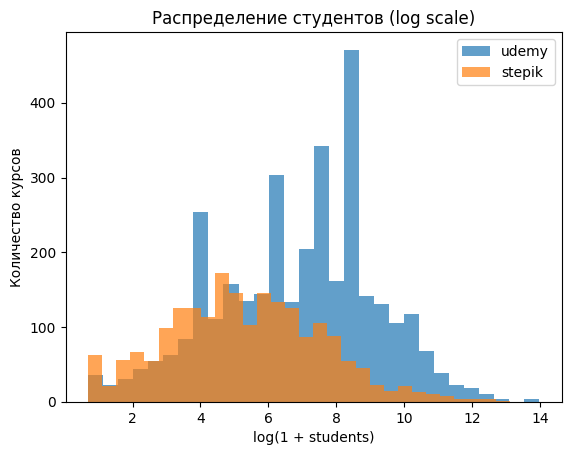

In [102]:
# Распределение студентов (log-scale)
import numpy as np

plt.figure()
for platform in all_courses["platform"].unique():
    subset = all_courses[all_courses["platform"] == platform]
    plt.hist(np.log1p(subset["students"]), bins=30, alpha=0.7, label=platform)

plt.title("Распределение студентов (log scale)")
plt.xlabel("log(1 + students)")
plt.ylabel("Количество курсов")
plt.legend()
plt.show()

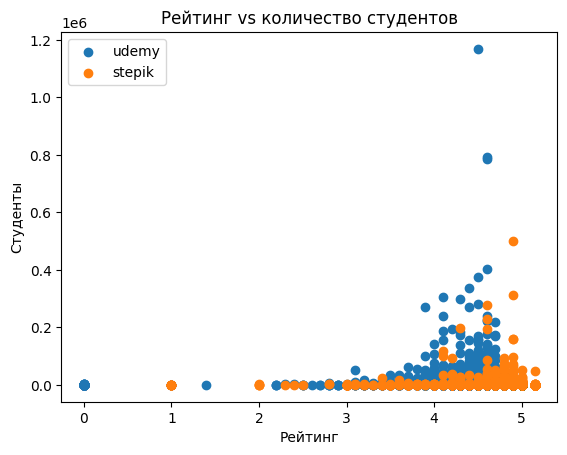

In [103]:
# Рейтинг vs студенты (проверить, коррелирует ли качество с масштабом.)
plt.figure()
for platform in all_courses["platform"].unique():
    subset = all_courses[all_courses["platform"] == platform]
    plt.scatter(subset["rating"], subset["students"], label=platform)

plt.title("Рейтинг vs количество студентов")
plt.xlabel("Рейтинг")
plt.ylabel("Студенты")
plt.legend()
plt.show()

## Промежуточный вывод
1. Несмотря на высокую долю бесплатного контента, платные курсы на Stepik характеризуются более высоким и более вариативным ценовым диапазоном. Udemy, в свою очередь, предлагает больше платных курсов по более низким и ограниченным ценам, что отражает стратегию массового рынка
2. Udemy — платформа с более крупными и “вирусными” курсами.
3. Stepik — платформа с более равномерным распределением и меньшими аудиториями.
4. Наблюдается положительная связь между рейтингом и количеством студентов: более высоко оценённые курсы обычно имеют больше студентов. При этом на Udemy разброс значительно выше и присутствуют курсы с очень большой аудиторией, тогда как на Stepik масштаб студентов заметно меньше.

## Проверка статистической значимости (Mann–Whitney U))

**A/B Тест 1: Влияет ли высокий рейтинг на вовлечённость?**

***Гипотеза***

- H₀: высокий рейтинг не влияет на количество студентов
- H₁: курсы с высоким рейтингом имеют больше студентов

***Метрики:***
1. Среднее количество студентов на курс (основная)
2. Показатель дохода (цена × количество студентов)


In [104]:
# Делим на группы
all_courses["rating_group"] = np.where(all_courses["rating"] >= 4.5,"High Rating","Other")

In [105]:
# Сравнение метрик (медианы)
all_courses.groupby("rating_group")["students"].median()

rating_group
High Rating    521.0
Other          917.0
Name: students, dtype: float64

<Figure size 640x480 with 0 Axes>

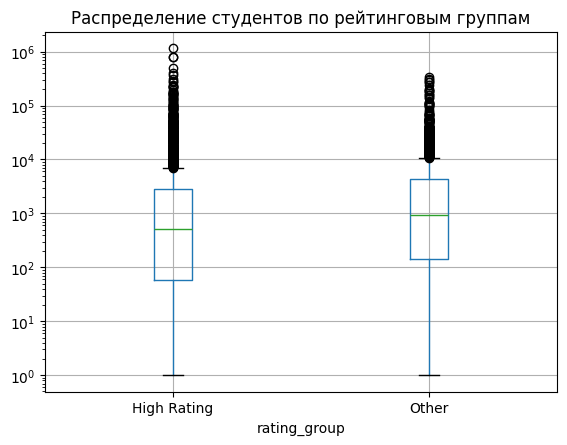

In [106]:
# Визуализация
plt.figure()
all_courses.boxplot(column="students", by="rating_group")
plt.yscale("log")
plt.suptitle("")
plt.title("Распределение студентов по рейтинговым группам")
plt.show()

In [107]:
# Статистический тест
from scipy.stats import mannwhitneyu

high = all_courses[all_courses["rating_group"]=="High Rating"]["students"]
other = all_courses[all_courses["rating_group"]=="Other"]["students"]

u_stat, p_value = mannwhitneyu(high, other, alternative='two-sided')
p_value


np.float64(1.375878627265655e-16)

In [108]:
p_value_f = max(p_value, 0.001)
p_value_f

0.001

## Промежуточный вывод
1. Так как  p = 0.001 < 0.05 то можно сделать вывод, что курсы с рейтингом ≥ 4.5 имеют статистически значимо больше студентов.
Добавление таких курсов может увеличить вовлечённость.


## Расчёт uplift (прироста)

**A/B Тест 2: Стоит ли выделять курсы с самым высоким рейтингом в результатах поиска?**
- Платформа хочет увеличить количество записей на курсы.
Есть гипотеза, что выделение курсов с высоким рейтингом повысит enrollment.

***Гипотеза***

- H₀: Control: обычная выдача
- H₁: Experimental: “Top Rated”

***Метрики:***
1. Количество зачислений на одного пользователя (или на один просмотр курса)(основная)
2. Доход на пользователя
3. Средняя цена
4. CTR
 

In [109]:
# Ограничиваем выборку (Чтобы убрать влияние цены)
filtered = all_courses[
    (all_courses["price"] > 0) &
    (all_courses["price"] < all_courses["price"].quantile(0.75))
].copy()

In [110]:
# Делим по рейтингу
filtered["rating_group"] = np.where(
    filtered["rating"] >= 4.5,
    "Experimental (Top Rated)",
    "Control"
)

In [111]:
# Проверяем баланс по цене 
filtered.groupby("rating_group")["price"].median()

rating_group
Control                     5191.310141
Experimental (Top Rated)    3200.000000
Name: price, dtype: float64

In [112]:
# Анализ эффекта (Enrollment)
filtered.groupby("rating_group")["students"].median()

rating_group
Control                     540.0
Experimental (Top Rated)    188.0
Name: students, dtype: float64

In [113]:
# Анализ эффекта (Revenue proxy)
filtered["revenue"] = filtered["price"] * filtered["students"]

filtered.groupby("rating_group")["revenue"].median()

rating_group
Control                     2.006423e+06
Experimental (Top Rated)    4.902100e+05
Name: revenue, dtype: float64

In [114]:
# Статистический тест
from scipy.stats import mannwhitneyu

experm = filtered[filtered["rating_group"]=="Experimental (Top Rated)"]["students"]
control = filtered[filtered["rating_group"]=="Control"]["students"]

u_stat, p_value = mannwhitneyu(experm, control)
p_value

np.float64(1.0575283934967433e-06)

In [115]:
p_value_f = max(p_value, 0.0001)
p_value_f

0.0001

In [116]:
# Effect Size (Статзначимость ≠ бизнес-значимость.)
uplift = (
    experm.median() - control.median()
) / control.median()

uplift = uplift  * 100
uplift_p = round(uplift, 2)
uplift_p

np.float64(-65.19)

## Промежуточный вывод
1. Экспериментальная группа показала снижение показателя на 65% по сравнению с контрольной, и это снижение статистически значимо (p < 0.001).
2. Эффект статистически значим, но не продуктово значим.